env.countstate =  4032
env.currentstate =  []
Episode number 0 completed with reward -182 and goal reward 0 in 173 steps 
Average reward after 0 episodes = : -182.0 
time elapsed in seconds =  26736.0047728


c:\Users\murtuza.morbiwala.sa\miniforge3\envs\soccerbot_env\lib\site-packages\ipykernel_launcher.py:109: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Episode number 1 completed with reward -200 and goal reward 0 in 200 steps 
Episode number 2 completed with reward -132 and goal reward 0 in 123 steps 
Episode number 3 completed with reward -153 and goal reward 0 in 144 steps 
Episode number 4 completed with reward -178 and goal reward 0 in 169 steps 
Episode number 5 completed with reward -200 and goal reward 0 in 200 steps 
Episode number 6 completed with reward -200 and goal reward 0 in 200 steps 
Episode number 7 completed with reward -105 and goal reward 0 in 96 steps 
Episode number 8 completed with reward -200 and goal reward 0 in 200 steps 
Episode number 9 completed with reward -200 and goal reward 0 in 200 steps 
Episode number 10 completed with reward -165 and goal reward 0 in 156 steps 
Episode number 11 completed with reward -200 and goal reward 0 in 200 steps 
Episode number 12 completed with reward -41 and goal reward 100 in 142 steps 
Episode number 13 completed with reward -200 and goal reward 0 in 200 steps 
Episode 

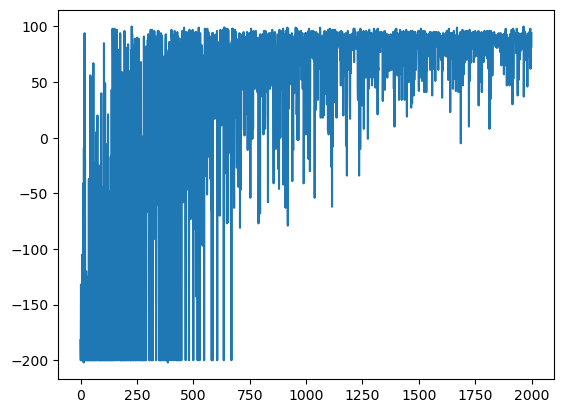

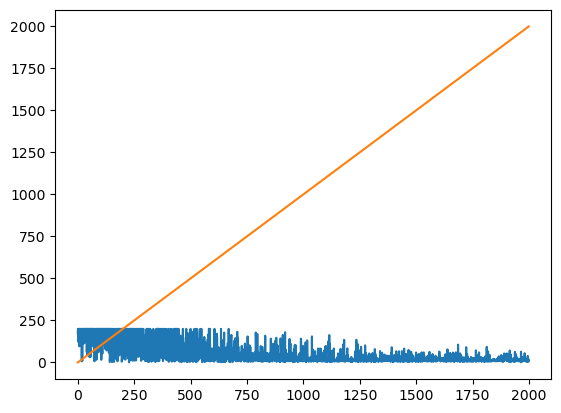

[[-182, 0], [-200, 1], [-132, 2], [-153, 3], [-178, 4], [-200, 5], [-200, 6], [-105, 7], [-200, 8], [-200, 9], [-165, 10], [-200, 11], [-41, 12], [-200, 13], [-202, 14], [-9, 15], [-200, 16], [-52, 17], [94, 18], [-131, 19], [-18, 20], [-200, 21], [-200, 22], [-151, 23], [-200, 24], [-120, 25], [-200, 26], [-200, 27], [-200, 28], [-200, 29], [-125, 30], [-200, 31], [-200, 32], [-200, 33], [-200, 34], [-200, 35], [-200, 36], [-37, 37], [-200, 38], [-200, 39], [-71, 40], [-200, 41], [-200, 42], [56, 43], [-200, 44], [-200, 45], [-200, 46], [-200, 47], [-200, 48], [-200, 49], [-200, 50], [-200, 51], [-41, 52], [-200, 53], [54, 54], [57, 55], [-200, 56], [67, 57], [-200, 58], [-22, 59], [-200, 60], [-200, 61], [-200, 62], [-200, 63], [-200, 64], [-64, 65], [-200, 66], [-200, 67], [-200, 68], [5, 69], [-200, 70], [-200, 71], [-200, 72], [-200, 73], [-16, 74], [20, 75], [-95, 76], [-31, 77], [-187, 78], [-200, 79], [-200, 80], [-200, 81], [-200, 82], [-25, 83], [-200, 84], [-200, 85], [-200,

In [58]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pylab as p
from  soccerworld_gym_env import SoccerWorld as sc
import time

import logging
from importlib import reload
reload(logging)
LOG_FILENAME = r'soccer.log'


logging.basicConfig(filename=LOG_FILENAME ,level=logging.DEBUG)

logging.debug('This message should go to the log file')
logging.info('So should this')
logging.warning('And this, too')


env = sc.Soccerworld()

#env = gym.make('FrozenLake-v0')

print ("env.countstate = ", env.countstate)
print ("env.currentstate = ", env.currentstate)


observations = env.countstate
actions = 4

tf.reset_default_graph()



#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,observations],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([observations,actions],0,0.01),name = 'W')
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,actions],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver([W])

# Set learning parameters
y = .99
e = 0.3
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
rList1 = []
rGoalList = []
with tf.Session() as sess:
    
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        rGoal = 0
        d = False
        j = 0
        #The Q-Network
        while j < 200:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(observations)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.actionspacesample()
            #print("Action Selected = ",a[0])
            #Get new state and reward from environment
            s1,r,d = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(observations)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(observations)[s:s+1],nextQ:targetQ})
            rAll += r
            if r>0:
                rGoal += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/75) + 10)
                break

        jList.append([j,i])
        rList.append(rAll)
        rList1.append([rAll,i])
        rGoalList.append([rGoal,i])

       
        print("Episode number {0} completed with reward {1} and goal reward {2} in {3} steps ".format(i, rAll, rGoal,j))

        if i%100 == 0:
            print("Average reward after {0} episodes = : {1} ".format(i, str(sum(rList) / (i + 1))))
            print("time elapsed in seconds = ", time.clock())
    
    save_path = saver.save(sess,'savemodel/model.ckpt')
#print("The weights for the neural network after episode {0} are: ".format(num_episodes, W1))
#print("Average reward after {0} episodes = : " + str(sum(rList)/num_episodes))




p.plot(rList)
p.show()
p.plot(jList)
p.show()


print(rList1)
print(jList)
print(rGoalList)


In [5]:
print("Hello, World!")

from soccerworld_gym_env import SoccerWorld as sc


Hello, World!


In [98]:
import tensorflow as tf
from soccerworld_gym_env import SoccerWorld as sc
import time
from IPython.display import clear_output
env = sc.Soccerworld()
import numpy as np
observations = env.countstate
actions = 4
e = 0.2

inputs1 = tf.placeholder(shape=[1,observations],dtype=tf.float32)

xa=3
ya=3
xb=4
yb=4

def soccerpredict(xa,ya,xb,yb):
    s = env.getstate(xa,ya,xb,yb)
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('savemodel/model.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('savemodel/'))
        graph = tf.get_default_graph()
        W = graph.get_tensor_by_name("W:0")
        Qout = tf.matmul(inputs1,W)
        predict = tf.argmax(Qout,1)
        a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(observations)[s:s+1]})
        return a[0]
    
soccerpredict(xa,ya,xb,yb)

    

INFO:tensorflow:Restoring parameters from savemodel/model.ckpt


3

In [7]:
import tensorflow as tf
from soccerworld_gym_env import SoccerWorld as sc
import time
from IPython.display import clear_output
env = sc.Soccerworld()
import numpy as np
observations = env.countstate
actions = 4
e = 0.2

inputs1 = tf.placeholder(shape=[1,observations],dtype=tf.float32)


def soccerpredictwiths(s):
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('savemodel/model.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('savemodel/'))
        graph = tf.get_default_graph()
        W = graph.get_tensor_by_name("W:0")
        Qout = tf.matmul(inputs1,W)
        predict = tf.argmax(Qout,1)
        a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(observations)[s:s+1]})
        return a[0]


s = env.reset()
d=False
name = 0

while True:
    s = env.reset()
    d=False    
    
    while True:
        a = soccerpredictwiths(s)
        
        s,r,d = env.step(a)        
        
        #clear_output()
        env.render()  
                 
        if d == True:
            break
    
    
    


INFO:tensorflow:Restoring parameters from savemodel/model.ckpt
INFO:tensorflow:Restoring parameters from savemodel/model.ckpt
INFO:tensorflow:Restoring parameters from savemodel/model.ckpt
INFO:tensorflow:Restoring parameters from savemodel/model.ckpt
INFO:tensorflow:Restoring parameters from savemodel/model.ckpt
INFO:tensorflow:Restoring parameters from savemodel/model.ckpt


KeyboardInterrupt: 

In [21]:
import os
folder = 'savemodel/'

os.listdir(folder) 

['model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta']

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [100, 12], [0, 13], [0, 14], [100, 15], [0, 16], [0, 17], [100, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [0, 33], [0, 34], [0, 35], [0, 36], [100, 37], [0, 38], [0, 39], [0, 40], [0, 41], [0, 42], [100, 43], [0, 44], [0, 45], [0, 46], [0, 47], [0, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [100, 54], [100, 55], [0, 56], [100, 57], [0, 58], [100, 59], [0, 60], [0, 61], [0, 62], [0, 63], [0, 64], [100, 65], [0, 66], [0, 67], [0, 68], [100, 69], [0, 70], [0, 71], [0, 72], [0, 73], [0, 74], [100, 75], [100, 76], [100, 77], [0, 78], [0, 79], [0, 80], [0, 81], [0, 82], [0, 83], [0, 84], [0, 85], [0, 86], [0, 87], [0, 88], [0, 89], [0, 90], [0, 91], [100, 92], [0, 93], [0, 94], [0, 95], [0, 96], [0, 97], [0, 98], [0, 99], [0, 100], [0, 101], [100, 102], [0, 103], [100, 104], [0, 105], [0, 106], [100,

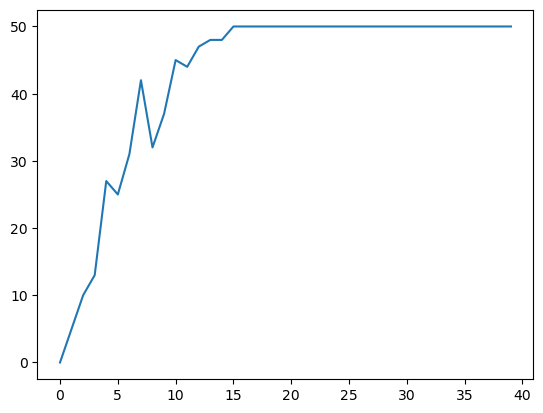

In [6]:
rGoalList = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [100, 12], [0, 13], [0, 14], [100, 15], [0, 16], [0, 17], [100, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [0, 33], [0, 34], [0, 35], [0, 36], [100, 37], [0, 38], [0, 39], [0, 40], [0, 41], [0, 42], [100, 43], [0, 44], [0, 45], [0, 46], [0, 47], [0, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [100, 54], [100, 55], [0, 56], [100, 57], [0, 58], [100, 59], [0, 60], [0, 61], [0, 62], [0, 63], [0, 64], [100, 65], [0, 66], [0, 67], [0, 68], [100, 69], [0, 70], [0, 71], [0, 72], [0, 73], [0, 74], [100, 75], [100, 76], [100, 77], [0, 78], [0, 79], [0, 80], [0, 81], [0, 82], [0, 83], [0, 84], [0, 85], [0, 86], [0, 87], [0, 88], [0, 89], [0, 90], [0, 91], [100, 92], [0, 93], [0, 94], [0, 95], [0, 96], [0, 97], [0, 98], [0, 99], [0, 100], [0, 101], [100, 102], [0, 103], [100, 104], [0, 105], [0, 106], [100, 107], [0, 108], [100, 109], [0, 110], [0, 111], [0, 112], [0, 113], [0, 114], [100, 115], [0, 116], [0, 117], [0, 118], [0, 119], [0, 120], [0, 121], [100, 122], [0, 123], [0, 124], [0, 125], [0, 126], [0, 127], [0, 128], [0, 129], [0, 130], [0, 131], [100, 132], [0, 133], [100, 134], [0, 135], [0, 136], [0, 137], [100, 138], [0, 139], [0, 140], [0, 141], [100, 142], [100, 143], [0, 144], [100, 145], [0, 146], [0, 147], [0, 148], [0, 149], [100, 150], [100, 151], [100, 152], [0, 153], [100, 154], [100, 155], [100, 156], [100, 157], [100, 158], [0, 159], [100, 160], [100, 161], [100, 162], [100, 163], [0, 164], [0, 165], [0, 166], [100, 167], [100, 168], [100, 169], [100, 170], [100, 171], [100, 172], [0, 173], [0, 174], [0, 175], [100, 176], [0, 177], [0, 178], [100, 179], [0, 180], [0, 181], [0, 182], [0, 183], [100, 184], [0, 185], [100, 186], [0, 187], [0, 188], [100, 189], [100, 190], [0, 191], [0, 192], [0, 193], [0, 194], [100, 195], [100, 196], [0, 197], [100, 198], [0, 199], [100, 200], [0, 201], [0, 202], [0, 203], [100, 204], [100, 205], [100, 206], [100, 207], [0, 208], [0, 209], [100, 210], [100, 211], [0, 212], [100, 213], [100, 214], [100, 215], [0, 216], [100, 217], [100, 218], [100, 219], [0, 220], [100, 221], [0, 222], [100, 223], [0, 224], [100, 225], [0, 226], [100, 227], [0, 228], [100, 229], [100, 230], [0, 231], [0, 232], [100, 233], [0, 234], [0, 235], [100, 236], [0, 237], [100, 238], [0, 239], [100, 240], [100, 241], [0, 242], [0, 243], [0, 244], [100, 245], [0, 246], [0, 247], [0, 248], [0, 249], [100, 250], [100, 251], [100, 252], [0, 253], [0, 254], [0, 255], [100, 256], [100, 257], [100, 258], [100, 259], [0, 260], [0, 261], [100, 262], [100, 263], [100, 264], [0, 265], [0, 266], [100, 267], [100, 268], [100, 269], [0, 270], [100, 271], [0, 272], [100, 273], [100, 274], [0, 275], [0, 276], [0, 277], [0, 278], [0, 279], [0, 280], [100, 281], [0, 282], [100, 283], [0, 284], [100, 285], [100, 286], [100, 287], [100, 288], [100, 289], [0, 290], [0, 291], [100, 292], [100, 293], [100, 294], [100, 295], [100, 296], [100, 297], [100, 298], [100, 299], [100, 300], [100, 301], [100, 302], [100, 303], [100, 304], [0, 305], [100, 306], [100, 307], [0, 308], [100, 309], [100, 310], [100, 311], [100, 312], [0, 313], [0, 314], [100, 315], [100, 316], [100, 317], [0, 318], [100, 319], [100, 320], [0, 321], [100, 322], [100, 323], [100, 324], [100, 325], [100, 326], [100, 327], [100, 328], [100, 329], [100, 330], [100, 331], [100, 332], [100, 333], [100, 334], [0, 335], [100, 336], [100, 337], [100, 338], [100, 339], [100, 340], [100, 341], [100, 342], [100, 343], [100, 344], [100, 345], [100, 346], [100, 347], [0, 348], [100, 349], [100, 350], [0, 351], [0, 352], [100, 353], [0, 354], [0, 355], [100, 356], [0, 357], [0, 358], [0, 359], [100, 360], [100, 361], [100, 362], [0, 363], [0, 364], [0, 365], [100, 366], [100, 367], [100, 368], [100, 369], [100, 370], [0, 371], [100, 372], [100, 373], [0, 374], [100, 375], [100, 376], [100, 377], [100, 378], [0, 379], [100, 380], [100, 381], [100, 382], [0, 383], [100, 384], [100, 385], [100, 386], [0, 387], [100, 388], [0, 389], [0, 390], [100, 391], [0, 392], [100, 393], [100, 394], [100, 395], [100, 396], [100, 397], [100, 398], [100, 399], [100, 400], [0, 401], [0, 402], [100, 403], [100, 404], [100, 405], [100, 406], [100, 407], [100, 408], [100, 409], [100, 410], [0, 411], [100, 412], [100, 413], [0, 414], [100, 415], [100, 416], [100, 417], [100, 418], [100, 419], [100, 420], [100, 421], [100, 422], [100, 423], [0, 424], [100, 425], [100, 426], [100, 427], [0, 428], [100, 429], [100, 430], [0, 431], [100, 432], [0, 433], [100, 434], [100, 435], [100, 436], [0, 437], [0, 438], [0, 439], [100, 440], [100, 441], [0, 442], [100, 443], [100, 444], [100, 445], [100, 446], [0, 447], [100, 448], [100, 449], [100, 450], [100, 451], [100, 452], [100, 453], [100, 454], [100, 455], [100, 456], [100, 457], [100, 458], [100, 459], [100, 460], [100, 461], [100, 462], [100, 463], [100, 464], [100, 465], [0, 466], [100, 467], [100, 468], [100, 469], [100, 470], [100, 471], [0, 472], [100, 473], [100, 474], [100, 475], [100, 476], [100, 477], [100, 478], [100, 479], [0, 480], [0, 481], [100, 482], [100, 483], [100, 484], [100, 485], [100, 486], [100, 487], [100, 488], [100, 489], [100, 490], [100, 491], [100, 492], [100, 493], [100, 494], [100, 495], [100, 496], [100, 497], [100, 498], [100, 499], [0, 500], [100, 501], [100, 502], [100, 503], [100, 504], [100, 505], [100, 506], [100, 507], [100, 508], [100, 509], [100, 510], [100, 511], [100, 512], [100, 513], [0, 514], [0, 515], [100, 516], [100, 517], [100, 518], [0, 519], [100, 520], [100, 521], [0, 522], [100, 523], [100, 524], [100, 525], [100, 526], [100, 527], [0, 528], [100, 529], [100, 530], [100, 531], [100, 532], [100, 533], [100, 534], [100, 535], [100, 536], [100, 537], [100, 538], [100, 539], [100, 540], [100, 541], [100, 542], [100, 543], [100, 544], [100, 545], [100, 546], [100, 547], [0, 548], [100, 549], [100, 550], [100, 551], [100, 552], [100, 553], [100, 554], [100, 555], [100, 556], [100, 557], [100, 558], [100, 559], [100, 560], [100, 561], [100, 562], [100, 563], [100, 564], [100, 565], [100, 566], [100, 567], [100, 568], [100, 569], [100, 570], [100, 571], [100, 572], [100, 573], [100, 574], [100, 575], [100, 576], [100, 577], [100, 578], [100, 579], [100, 580], [0, 581], [0, 582], [100, 583], [100, 584], [100, 585], [0, 586], [100, 587], [100, 588], [100, 589], [100, 590], [100, 591], [100, 592], [100, 593], [100, 594], [100, 595], [100, 596], [100, 597], [100, 598], [100, 599], [100, 600], [100, 601], [100, 602], [100, 603], [100, 604], [100, 605], [0, 606], [100, 607], [100, 608], [100, 609], [100, 610], [100, 611], [100, 612], [100, 613], [100, 614], [100, 615], [100, 616], [100, 617], [100, 618], [100, 619], [100, 620], [100, 621], [100, 622], [100, 623], [100, 624], [100, 625], [100, 626], [100, 627], [100, 628], [100, 629], [100, 630], [100, 631], [100, 632], [100, 633], [100, 634], [0, 635], [100, 636], [100, 637], [100, 638], [100, 639], [100, 640], [100, 641], [100, 642], [100, 643], [100, 644], [100, 645], [100, 646], [100, 647], [100, 648], [100, 649], [100, 650], [100, 651], [100, 652], [100, 653], [0, 654], [100, 655], [100, 656], [100, 657], [100, 658], [100, 659], [100, 660], [100, 661], [100, 662], [100, 663], [100, 664], [100, 665], [100, 666], [100, 667], [100, 668], [0, 669], [100, 670], [100, 671], [100, 672], [100, 673], [100, 674], [100, 675], [100, 676], [100, 677], [100, 678], [100, 679], [100, 680], [100, 681], [100, 682], [100, 683], [100, 684], [100, 685], [100, 686], [100, 687], [100, 688], [100, 689], [100, 690], [100, 691], [100, 692], [100, 693], [100, 694], [100, 695], [100, 696], [100, 697], [100, 698], [100, 699], [100, 700], [100, 701], [100, 702], [100, 703], [100, 704], [100, 705], [100, 706], [100, 707], [100, 708], [100, 709], [100, 710], [100, 711], [100, 712], [100, 713], [100, 714], [100, 715], [100, 716], [100, 717], [100, 718], [100, 719], [100, 720], [100, 721], [100, 722], [100, 723], [100, 724], [100, 725], [100, 726], [100, 727], [100, 728], [100, 729], [100, 730], [100, 731], [100, 732], [100, 733], [100, 734], [100, 735], [100, 736], [100, 737], [100, 738], [100, 739], [100, 740], [100, 741], [100, 742], [100, 743], [100, 744], [100, 745], [100, 746], [100, 747], [100, 748], [100, 749], [100, 750], [100, 751], [100, 752], [100, 753], [100, 754], [100, 755], [100, 756], [100, 757], [100, 758], [100, 759], [100, 760], [100, 761], [100, 762], [100, 763], [100, 764], [100, 765], [100, 766], [100, 767], [100, 768], [100, 769], [100, 770], [100, 771], [100, 772], [100, 773], [100, 774], [100, 775], [100, 776], [100, 777], [100, 778], [100, 779], [100, 780], [100, 781], [100, 782], [100, 783], [100, 784], [100, 785], [100, 786], [100, 787], [100, 788], [100, 789], [100, 790], [100, 791], [100, 792], [100, 793], [100, 794], [100, 795], [100, 796], [100, 797], [100, 798], [100, 799], [100, 800], [100, 801], [100, 802], [100, 803], [100, 804], [100, 805], [100, 806], [100, 807], [100, 808], [100, 809], [100, 810], [100, 811], [100, 812], [100, 813], [100, 814], [100, 815], [100, 816], [100, 817], [100, 818], [100, 819], [100, 820], [100, 821], [100, 822], [100, 823], [100, 824], [100, 825], [100, 826], [100, 827], [100, 828], [100, 829], [100, 830], [100, 831], [100, 832], [100, 833], [100, 834], [100, 835], [100, 836], [100, 837], [100, 838], [100, 839], [100, 840], [100, 841], [100, 842], [100, 843], [100, 844], [100, 845], [100, 846], [100, 847], [100, 848], [100, 849], [100, 850], [100, 851], [100, 852], [100, 853], [100, 854], [100, 855], [100, 856], [100, 857], [100, 858], [100, 859], [100, 860], [100, 861], [100, 862], [100, 863], [100, 864], [100, 865], [100, 866], [100, 867], [100, 868], [100, 869], [100, 870], [100, 871], [100, 872], [100, 873], [100, 874], [100, 875], [100, 876], [100, 877], [100, 878], [100, 879], [100, 880], [100, 881], [100, 882], [100, 883], [100, 884], [100, 885], [100, 886], [100, 887], [100, 888], [100, 889], [100, 890], [100, 891], [100, 892], [100, 893], [100, 894], [100, 895], [100, 896], [100, 897], [100, 898], [100, 899], [100, 900], [100, 901], [100, 902], [100, 903], [100, 904], [100, 905], [100, 906], [100, 907], [100, 908], [100, 909], [100, 910], [100, 911], [100, 912], [100, 913], [100, 914], [100, 915], [100, 916], [100, 917], [100, 918], [100, 919], [100, 920], [100, 921], [100, 922], [100, 923], [100, 924], [100, 925], [100, 926], [100, 927], [100, 928], [100, 929], [100, 930], [100, 931], [100, 932], [100, 933], [100, 934], [100, 935], [100, 936], [100, 937], [100, 938], [100, 939], [100, 940], [100, 941], [100, 942], [100, 943], [100, 944], [100, 945], [100, 946], [100, 947], [100, 948], [100, 949], [100, 950], [100, 951], [100, 952], [100, 953], [100, 954], [100, 955], [100, 956], [100, 957], [100, 958], [100, 959], [100, 960], [100, 961], [100, 962], [100, 963], [100, 964], [100, 965], [100, 966], [100, 967], [100, 968], [100, 969], [100, 970], [100, 971], [100, 972], [100, 973], [100, 974], [100, 975], [100, 976], [100, 977], [100, 978], [100, 979], [100, 980], [100, 981], [100, 982], [100, 983], [100, 984], [100, 985], [100, 986], [100, 987], [100, 988], [100, 989], [100, 990], [100, 991], [100, 992], [100, 993], [100, 994], [100, 995], [100, 996], [100, 997], [100, 998], [100, 999], [100, 1000], [100, 1001], [100, 1002], [100, 1003], [100, 1004], [100, 1005], [100, 1006], [100, 1007], [100, 1008], [100, 1009], [100, 1010], [100, 1011], [100, 1012], [100, 1013], [100, 1014], [100, 1015], [100, 1016], [100, 1017], [100, 1018], [100, 1019], [100, 1020], [100, 1021], [100, 1022], [100, 1023], [100, 1024], [100, 1025], [100, 1026], [100, 1027], [100, 1028], [100, 1029], [100, 1030], [100, 1031], [100, 1032], [100, 1033], [100, 1034], [100, 1035], [100, 1036], [100, 1037], [100, 1038], [100, 1039], [100, 1040], [100, 1041], [100, 1042], [100, 1043], [100, 1044], [100, 1045], [100, 1046], [100, 1047], [100, 1048], [100, 1049], [100, 1050], [100, 1051], [100, 1052], [100, 1053], [100, 1054], [100, 1055], [100, 1056], [100, 1057], [100, 1058], [100, 1059], [100, 1060], [100, 1061], [100, 1062], [100, 1063], [100, 1064], [100, 1065], [100, 1066], [100, 1067], [100, 1068], [100, 1069], [100, 1070], [100, 1071], [100, 1072], [100, 1073], [100, 1074], [100, 1075], [100, 1076], [100, 1077], [100, 1078], [100, 1079], [100, 1080], [100, 1081], [100, 1082], [100, 1083], [100, 1084], [100, 1085], [100, 1086], [100, 1087], [100, 1088], [100, 1089], [100, 1090], [100, 1091], [100, 1092], [100, 1093], [100, 1094], [100, 1095], [100, 1096], [100, 1097], [100, 1098], [100, 1099], [100, 1100], [100, 1101], [100, 1102], [100, 1103], [100, 1104], [100, 1105], [100, 1106], [100, 1107], [100, 1108], [100, 1109], [100, 1110], [100, 1111], [100, 1112], [100, 1113], [100, 1114], [100, 1115], [100, 1116], [100, 1117], [100, 1118], [100, 1119], [100, 1120], [100, 1121], [100, 1122], [100, 1123], [100, 1124], [100, 1125], [100, 1126], [100, 1127], [100, 1128], [100, 1129], [100, 1130], [100, 1131], [100, 1132], [100, 1133], [100, 1134], [100, 1135], [100, 1136], [100, 1137], [100, 1138], [100, 1139], [100, 1140], [100, 1141], [100, 1142], [100, 1143], [100, 1144], [100, 1145], [100, 1146], [100, 1147], [100, 1148], [100, 1149], [100, 1150], [100, 1151], [100, 1152], [100, 1153], [100, 1154], [100, 1155], [100, 1156], [100, 1157], [100, 1158], [100, 1159], [100, 1160], [100, 1161], [100, 1162], [100, 1163], [100, 1164], [100, 1165], [100, 1166], [100, 1167], [100, 1168], [100, 1169], [100, 1170], [100, 1171], [100, 1172], [100, 1173], [100, 1174], [100, 1175], [100, 1176], [100, 1177], [100, 1178], [100, 1179], [100, 1180], [100, 1181], [100, 1182], [100, 1183], [100, 1184], [100, 1185], [100, 1186], [100, 1187], [100, 1188], [100, 1189], [100, 1190], [100, 1191], [100, 1192], [100, 1193], [100, 1194], [100, 1195], [100, 1196], [100, 1197], [100, 1198], [100, 1199], [100, 1200], [100, 1201], [100, 1202], [100, 1203], [100, 1204], [100, 1205], [100, 1206], [100, 1207], [100, 1208], [100, 1209], [100, 1210], [100, 1211], [100, 1212], [100, 1213], [100, 1214], [100, 1215], [100, 1216], [100, 1217], [100, 1218], [100, 1219], [100, 1220], [100, 1221], [100, 1222], [100, 1223], [100, 1224], [100, 1225], [100, 1226], [100, 1227], [100, 1228], [100, 1229], [100, 1230], [100, 1231], [100, 1232], [100, 1233], [100, 1234], [100, 1235], [100, 1236], [100, 1237], [100, 1238], [100, 1239], [100, 1240], [100, 1241], [100, 1242], [100, 1243], [100, 1244], [100, 1245], [100, 1246], [100, 1247], [100, 1248], [100, 1249], [100, 1250], [100, 1251], [100, 1252], [100, 1253], [100, 1254], [100, 1255], [100, 1256], [100, 1257], [100, 1258], [100, 1259], [100, 1260], [100, 1261], [100, 1262], [100, 1263], [100, 1264], [100, 1265], [100, 1266], [100, 1267], [100, 1268], [100, 1269], [100, 1270], [100, 1271], [100, 1272], [100, 1273], [100, 1274], [100, 1275], [100, 1276], [100, 1277], [100, 1278], [100, 1279], [100, 1280], [100, 1281], [100, 1282], [100, 1283], [100, 1284], [100, 1285], [100, 1286], [100, 1287], [100, 1288], [100, 1289], [100, 1290], [100, 1291], [100, 1292], [100, 1293], [100, 1294], [100, 1295], [100, 1296], [100, 1297], [100, 1298], [100, 1299], [100, 1300], [100, 1301], [100, 1302], [100, 1303], [100, 1304], [100, 1305], [100, 1306], [100, 1307], [100, 1308], [100, 1309], [100, 1310], [100, 1311], [100, 1312], [100, 1313], [100, 1314], [100, 1315], [100, 1316], [100, 1317], [100, 1318], [100, 1319], [100, 1320], [100, 1321], [100, 1322], [100, 1323], [100, 1324], [100, 1325], [100, 1326], [100, 1327], [100, 1328], [100, 1329], [100, 1330], [100, 1331], [100, 1332], [100, 1333], [100, 1334], [100, 1335], [100, 1336], [100, 1337], [100, 1338], [100, 1339], [100, 1340], [100, 1341], [100, 1342], [100, 1343], [100, 1344], [100, 1345], [100, 1346], [100, 1347], [100, 1348], [100, 1349], [100, 1350], [100, 1351], [100, 1352], [100, 1353], [100, 1354], [100, 1355], [100, 1356], [100, 1357], [100, 1358], [100, 1359], [100, 1360], [100, 1361], [100, 1362], [100, 1363], [100, 1364], [100, 1365], [100, 1366], [100, 1367], [100, 1368], [100, 1369], [100, 1370], [100, 1371], [100, 1372], [100, 1373], [100, 1374], [100, 1375], [100, 1376], [100, 1377], [100, 1378], [100, 1379], [100, 1380], [100, 1381], [100, 1382], [100, 1383], [100, 1384], [100, 1385], [100, 1386], [100, 1387], [100, 1388], [100, 1389], [100, 1390], [100, 1391], [100, 1392], [100, 1393], [100, 1394], [100, 1395], [100, 1396], [100, 1397], [100, 1398], [100, 1399], [100, 1400], [100, 1401], [100, 1402], [100, 1403], [100, 1404], [100, 1405], [100, 1406], [100, 1407], [100, 1408], [100, 1409], [100, 1410], [100, 1411], [100, 1412], [100, 1413], [100, 1414], [100, 1415], [100, 1416], [100, 1417], [100, 1418], [100, 1419], [100, 1420], [100, 1421], [100, 1422], [100, 1423], [100, 1424], [100, 1425], [100, 1426], [100, 1427], [100, 1428], [100, 1429], [100, 1430], [100, 1431], [100, 1432], [100, 1433], [100, 1434], [100, 1435], [100, 1436], [100, 1437], [100, 1438], [100, 1439], [100, 1440], [100, 1441], [100, 1442], [100, 1443], [100, 1444], [100, 1445], [100, 1446], [100, 1447], [100, 1448], [100, 1449], [100, 1450], [100, 1451], [100, 1452], [100, 1453], [100, 1454], [100, 1455], [100, 1456], [100, 1457], [100, 1458], [100, 1459], [100, 1460], [100, 1461], [100, 1462], [100, 1463], [100, 1464], [100, 1465], [100, 1466], [100, 1467], [100, 1468], [100, 1469], [100, 1470], [100, 1471], [100, 1472], [100, 1473], [100, 1474], [100, 1475], [100, 1476], [100, 1477], [100, 1478], [100, 1479], [100, 1480], [100, 1481], [100, 1482], [100, 1483], [100, 1484], [100, 1485], [100, 1486], [100, 1487], [100, 1488], [100, 1489], [100, 1490], [100, 1491], [100, 1492], [100, 1493], [100, 1494], [100, 1495], [100, 1496], [100, 1497], [100, 1498], [100, 1499], [100, 1500], [100, 1501], [100, 1502], [100, 1503], [100, 1504], [100, 1505], [100, 1506], [100, 1507], [100, 1508], [100, 1509], [100, 1510], [100, 1511], [100, 1512], [100, 1513], [100, 1514], [100, 1515], [100, 1516], [100, 1517], [100, 1518], [100, 1519], [100, 1520], [100, 1521], [100, 1522], [100, 1523], [100, 1524], [100, 1525], [100, 1526], [100, 1527], [100, 1528], [100, 1529], [100, 1530], [100, 1531], [100, 1532], [100, 1533], [100, 1534], [100, 1535], [100, 1536], [100, 1537], [100, 1538], [100, 1539], [100, 1540], [100, 1541], [100, 1542], [100, 1543], [100, 1544], [100, 1545], [100, 1546], [100, 1547], [100, 1548], [100, 1549], [100, 1550], [100, 1551], [100, 1552], [100, 1553], [100, 1554], [100, 1555], [100, 1556], [100, 1557], [100, 1558], [100, 1559], [100, 1560], [100, 1561], [100, 1562], [100, 1563], [100, 1564], [100, 1565], [100, 1566], [100, 1567], [100, 1568], [100, 1569], [100, 1570], [100, 1571], [100, 1572], [100, 1573], [100, 1574], [100, 1575], [100, 1576], [100, 1577], [100, 1578], [100, 1579], [100, 1580], [100, 1581], [100, 1582], [100, 1583], [100, 1584], [100, 1585], [100, 1586], [100, 1587], [100, 1588], [100, 1589], [100, 1590], [100, 1591], [100, 1592], [100, 1593], [100, 1594], [100, 1595], [100, 1596], [100, 1597], [100, 1598], [100, 1599], [100, 1600], [100, 1601], [100, 1602], [100, 1603], [100, 1604], [100, 1605], [100, 1606], [100, 1607], [100, 1608], [100, 1609], [100, 1610], [100, 1611], [100, 1612], [100, 1613], [100, 1614], [100, 1615], [100, 1616], [100, 1617], [100, 1618], [100, 1619], [100, 1620], [100, 1621], [100, 1622], [100, 1623], [100, 1624], [100, 1625], [100, 1626], [100, 1627], [100, 1628], [100, 1629], [100, 1630], [100, 1631], [100, 1632], [100, 1633], [100, 1634], [100, 1635], [100, 1636], [100, 1637], [100, 1638], [100, 1639], [100, 1640], [100, 1641], [100, 1642], [100, 1643], [100, 1644], [100, 1645], [100, 1646], [100, 1647], [100, 1648], [100, 1649], [100, 1650], [100, 1651], [100, 1652], [100, 1653], [100, 1654], [100, 1655], [100, 1656], [100, 1657], [100, 1658], [100, 1659], [100, 1660], [100, 1661], [100, 1662], [100, 1663], [100, 1664], [100, 1665], [100, 1666], [100, 1667], [100, 1668], [100, 1669], [100, 1670], [100, 1671], [100, 1672], [100, 1673], [100, 1674], [100, 1675], [100, 1676], [100, 1677], [100, 1678], [100, 1679], [100, 1680], [100, 1681], [100, 1682], [100, 1683], [100, 1684], [100, 1685], [100, 1686], [100, 1687], [100, 1688], [100, 1689], [100, 1690], [100, 1691], [100, 1692], [100, 1693], [100, 1694], [100, 1695], [100, 1696], [100, 1697], [100, 1698], [100, 1699], [100, 1700], [100, 1701], [100, 1702], [100, 1703], [100, 1704], [100, 1705], [100, 1706], [100, 1707], [100, 1708], [100, 1709], [100, 1710], [100, 1711], [100, 1712], [100, 1713], [100, 1714], [100, 1715], [100, 1716], [100, 1717], [100, 1718], [100, 1719], [100, 1720], [100, 1721], [100, 1722], [100, 1723], [100, 1724], [100, 1725], [100, 1726], [100, 1727], [100, 1728], [100, 1729], [100, 1730], [100, 1731], [100, 1732], [100, 1733], [100, 1734], [100, 1735], [100, 1736], [100, 1737], [100, 1738], [100, 1739], [100, 1740], [100, 1741], [100, 1742], [100, 1743], [100, 1744], [100, 1745], [100, 1746], [100, 1747], [100, 1748], [100, 1749], [100, 1750], [100, 1751], [100, 1752], [100, 1753], [100, 1754], [100, 1755], [100, 1756], [100, 1757], [100, 1758], [100, 1759], [100, 1760], [100, 1761], [100, 1762], [100, 1763], [100, 1764], [100, 1765], [100, 1766], [100, 1767], [100, 1768], [100, 1769], [100, 1770], [100, 1771], [100, 1772], [100, 1773], [100, 1774], [100, 1775], [100, 1776], [100, 1777], [100, 1778], [100, 1779], [100, 1780], [100, 1781], [100, 1782], [100, 1783], [100, 1784], [100, 1785], [100, 1786], [100, 1787], [100, 1788], [100, 1789], [100, 1790], [100, 1791], [100, 1792], [100, 1793], [100, 1794], [100, 1795], [100, 1796], [100, 1797], [100, 1798], [100, 1799], [100, 1800], [100, 1801], [100, 1802], [100, 1803], [100, 1804], [100, 1805], [100, 1806], [100, 1807], [100, 1808], [100, 1809], [100, 1810], [100, 1811], [100, 1812], [100, 1813], [100, 1814], [100, 1815], [100, 1816], [100, 1817], [100, 1818], [100, 1819], [100, 1820], [100, 1821], [100, 1822], [100, 1823], [100, 1824], [100, 1825], [100, 1826], [100, 1827], [100, 1828], [100, 1829], [100, 1830], [100, 1831], [100, 1832], [100, 1833], [100, 1834], [100, 1835], [100, 1836], [100, 1837], [100, 1838], [100, 1839], [100, 1840], [100, 1841], [100, 1842], [100, 1843], [100, 1844], [100, 1845], [100, 1846], [100, 1847], [100, 1848], [100, 1849], [100, 1850], [100, 1851], [100, 1852], [100, 1853], [100, 1854], [100, 1855], [100, 1856], [100, 1857], [100, 1858], [100, 1859], [100, 1860], [100, 1861], [100, 1862], [100, 1863], [100, 1864], [100, 1865], [100, 1866], [100, 1867], [100, 1868], [100, 1869], [100, 1870], [100, 1871], [100, 1872], [100, 1873], [100, 1874], [100, 1875], [100, 1876], [100, 1877], [100, 1878], [100, 1879], [100, 1880], [100, 1881], [100, 1882], [100, 1883], [100, 1884], [100, 1885], [100, 1886], [100, 1887], [100, 1888], [100, 1889], [100, 1890], [100, 1891], [100, 1892], [100, 1893], [100, 1894], [100, 1895], [100, 1896], [100, 1897], [100, 1898], [100, 1899], [100, 1900], [100, 1901], [100, 1902], [100, 1903], [100, 1904], [100, 1905], [100, 1906], [100, 1907], [100, 1908], [100, 1909], [100, 1910], [100, 1911], [100, 1912], [100, 1913], [100, 1914], [100, 1915], [100, 1916], [100, 1917], [100, 1918], [100, 1919], [100, 1920], [100, 1921], [100, 1922], [100, 1923], [100, 1924], [100, 1925], [100, 1926], [100, 1927], [100, 1928], [100, 1929], [100, 1930], [100, 1931], [100, 1932], [100, 1933], [100, 1934], [100, 1935], [100, 1936], [100, 1937], [100, 1938], [100, 1939], [100, 1940], [100, 1941], [100, 1942], [100, 1943], [100, 1944], [100, 1945], [100, 1946], [100, 1947], [100, 1948], [100, 1949], [100, 1950], [100, 1951], [100, 1952], [100, 1953], [100, 1954], [100, 1955], [100, 1956], [100, 1957], [100, 1958], [100, 1959], [100, 1960], [100, 1961], [100, 1962], [100, 1963], [100, 1964], [100, 1965], [100, 1966], [100, 1967], [100, 1968], [100, 1969], [100, 1970], [100, 1971], [100, 1972], [100, 1973], [100, 1974], [100, 1975], [100, 1976], [100, 1977], [100, 1978], [100, 1979], [100, 1980], [100, 1981], [100, 1982], [100, 1983], [100, 1984], [100, 1985], [100, 1986], [100, 1987], [100, 1988], [100, 1989], [100, 1990], [100, 1991], [100, 1992], [100, 1993], [100, 1994], [100, 1995], [100, 1996], [100, 1997], [100, 1998], [100, 1999]]

import matplotlib.pyplot as plt
print(rGoalList)

c = 0
trend = []
for point in rGoalList:
    #id poit[0] is 100 then count it and plot it every 10 point[1] as a line
    

    if point[0] == 100:
        c=c+1  
    if point[1] % 50 == 0:
        trend.append(c)
        c=0
        
plt.plot(trend)